In [1]:
import os
import imageio as iio
from skan import pre, csr
import imageio
import tifffile as tiff
from tqdm import tqdm
import numpy as np
from skimage import morphology
import pandas as pd
from skan.image_stats import image_summary
from skimage.feature import shape_index
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing as mp

In [2]:
CPU_COUNT = int(os.environ.get('CPU_COUNT', mp.cpu_count()))

In [3]:
from skan import pipe

In [4]:
def time_point(filename):
    
    main_filename = filename[:filename.index('.tif')]

    timepoint = main_filename.split('-')[1]
    time_point = int(timepoint)

    return time_point


def process_single_cilia_image(filename, new_output_path, image_format, scale_metadata_path,
                               threshold_radius, smooth_radius,brightness_offset, 
                               crop_radius, smooth_method):
    image = imageio.imread(filename, format=image_format)
    scale = pipe._get_scale(image, scale_metadata_path)
    if crop_radius > 0:
        c = crop_radius
        image = image[c:-c, c:-c]
    pixel_threshold_radius = int(np.ceil(threshold_radius / scale))
    

#     scale_micron = 1/scale
    pixel_smoothing_radius = smooth_radius / scale
    
#     print ("pixel_threshold_radius =", pixel_threshold_radius)
#     print ("pixel_smoothing_radius =", pixel_smoothing_radius)
    thresholded = pre.threshold(image, sigma=pixel_smoothing_radius,
                                radius=pixel_threshold_radius,
                                offset=brightness_offset,
                                smooth_method=smooth_method)
    
    new_img_name = filename.split('/')[-1]
#     print (new_img_name)

    tiff.imsave(new_output_path+"bin_"+new_img_name, thresholded)

    
    quality = shape_index(image, sigma=pixel_smoothing_radius,
                          mode='reflect')
    skeleton = morphology.skeletonize(thresholded) * quality
    framedata = csr.summarise(skeleton, spacing=1/scale)
    framedata['squiggle'] = np.log2(framedata['branch-distance'] /
                                    framedata['euclidean-distance'])
    framedata['scale'] = 1/scale
    framedata.rename(columns={'mean pixel value': 'mean shape index'},
                     inplace=True)
    framedata['filename'] = filename.split("/")[-1]   
    framedata['time'] = time_point(filename)

    
    none_skls = framedata.index[framedata['skeleton-id'] == 1]     
    skls0 = framedata.loc[framedata.index.difference(none_skls)]
#     skls1 = skls0[(skls0['branch-type'] == 0) & (skls0['branch-distance']<7)]
#     cilia_skl = skls1.loc[[skls1['branch-distance'].idxmax()]]
    cilia_skl = skls0.loc[[skls0['branch-distance'].idxmax()]]

    
    return image, thresholded, skeleton, framedata, cilia_skl


CPU_COUNT = int(os.environ.get('CPU_COUNT', mp.cpu_count()))
def process_cilia_images(filenames, output_path, image_format, threshold_radius,smooth_radius, 
                         brightness_offset, scale_metadata_path, crop_radius=0, 
                         smooth_method='Gaussian', num_threads=CPU_COUNT):
    """Full pipeline from images to skeleton stats with local median threshold.

    Parameters
    ----------
    filenames : list of string
        The list of input filenames.
    image_format : string
        The format of the files. 'auto' is automatically determined by the
        imageio library. See imageio documentation for valid image formats.
    threshold_radius : float
        The radius for median thresholding,
    smooth_radius : float in [0, 1]
        The value of sigma with which to Gaussian-smooth the image,
        **relative to `threshold_radius`**.
    brightness_offset : float
        The standard brightness value with which to threshold is the local
        median, `m(x, y)`. Use this value to offset from there: the threshold
        used will be `m(x, y) + brightness_offset`.
    scale_metadata_path : string
        The path in the image dictionary to find the metadata on pixel scale,
        separated by forward slashes ('/').
    crop_radius : int, optional
        Crop `crop_radius` pixels from each margin of the image before
        processing.
    smooth_method : {'Gaussian', 'TV', 'NL'}, optional
        Which method to use for smoothing.
    num_threads : int, optional
        How many threads to use for computation. This should generally be
        set to the number of CPU cores available to you.

    Returns
    -------
    results : generator
        The pipeline yields individual image results in the form of a tuple
        of ``(filename, image, thresholded_image, skeleton, data_frame)``.
        Finally, after all the images have been processed, the pipeline yields
        a DataFrame containing all the collated branch-level results.
    """
    
    new_output_path = output_path+'Binary_Images/'
    try: 
        os.mkdir(output_path+'Binary_Images/')
    except:
        pass

    
    image_format = None if image_format == 'auto' else image_format
    results = []
    image_results = []
    cilia_results = []
    with ThreadPoolExecutor(max_workers=num_threads) as ex:
        future_data = {ex.submit(process_single_cilia_image, filename, new_output_path,
                                 image_format, scale_metadata_path, threshold_radius, 
                                 smooth_radius, brightness_offset, crop_radius,
                                 smooth_method): filename
                       for filename in filenames}
        for completed_data in tqdm(as_completed(future_data)):
            image, thresholded, skeleton, framedata, cilia_skl = completed_data.result()
            filename = future_data[completed_data]
            results.append(framedata)
            cilia_results.append(cilia_skl)
            image_stats = image_summary(skeleton,
                                        spacing=framedata['scale'][0])
            image_stats['filename'] = filename
            image_stats['branch density'] = (framedata.shape[0] /
                                             image_stats['area'])
            j2j = framedata[framedata['branch-type'] == 2]
            image_stats['mean J2J branch distance'] = (
                                            j2j['branch-distance'].mean())
            image_results.append(image_stats)
            yield filename, image, thresholded, skeleton, framedata, cilia_skl      
    yield pd.concat(results), pd.concat(image_results), pd.concat(cilia_results)


In [48]:
import toolz as tz
from glob import glob

cilia_files = glob('/Volumes/Xiang4TData/STMND1/220207_RPE_Cilia_PTX_Live/220207_Processed/220207_rpe_cilia_stmnd1_600nmptx_live_00105_cilia2_processed/Threshold_Images/*.tif')
# cilia_files = glob('/Volumes/Xiang4TData/STMND1/220203_RPE_Cilia_Live/220203_rpe_cilia_live_001_xy04_cilia1_processed/bkgSub_Images/*.tif')

print (tz.last(cilia_files))
# print (cilia_files)



/Volumes/Xiang4TData/STMND1/220207_RPE_Cilia_PTX_Live/220207_Processed/220207_rpe_cilia_stmnd1_600nmptx_live_00105_cilia2_processed/Threshold_Images/thrshld_bkg_220207_rpe_cilia_stmnd1_600nmptx_live_00105_cilia2-0057.tif


In [49]:
# output_path= "/Volumes/Xiang4TData/STMND1/220203_RPE_Cilia_Live/220203_rpe_cilia_live_001_xy01_cilia2_processed/",

data, per_image_data, cilia_data= tz.last(process_cilia_images(
    cilia_files,
    output_path= "/Volumes/Xiang4TData/STMND1/220207_RPE_Cilia_PTX_Live/220207_Processed/220207_rpe_cilia_stmnd1_600nmptx_live_00105_cilia2_processed/",
    image_format='auto',
    threshold_radius=2,
    smooth_radius=80,  #change this number to set cutoff radius, the bigger the fatter, the more connection
    brightness_offset=0.0,
    scale_metadata_path= 15.3846,
    crop_radius=0,
    smooth_method='Gaussian'
))

# read out data   
output_name = cilia_files[0].split('-')[0]+"_summary.csv"
cilia_data_sorted = cilia_data.sort_values("time")
cilia_data_sorted.to_csv(output_name, index=False)


0it [00:00, ?it/s]/opt/anaconda3/lib/python3.8/site-packages/skan/vendored/thresholding.py:122: RuntimeWarning: invalid value encountered in sqrt
  s = np.sqrt(g2 - m * m)
/opt/anaconda3/lib/python3.8/site-packages/skimage/feature/corner.py:397: RuntimeWarning: invalid value encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))
/opt/anaconda3/lib/python3.8/site-packages/skimage/feature/corner.py:397: RuntimeWarning: divide by zero encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for sli

/opt/anaconda3/lib/python3.8/site-packages/skan/vendored/thresholding.py:122: RuntimeWarning: invalid value encountered in sqrt
  s = np.sqrt(g2 - m * m)
/opt/anaconda3/lib/python3.8/site-packages/skimage/feature/corner.py:397: RuntimeWarning: invalid value encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.tr

/opt/anaconda3/lib/python3.8/site-packages/skan/vendored/thresholding.py:122: RuntimeWarning: invalid value encountered in sqrt
  s = np.sqrt(g2 - m * m)
44it [00:01, 33.93it/s]/opt/anaconda3/lib/python3.8/site-packages/skan/vendored/thresholding.py:122: RuntimeWarning: invalid value encountered in sqrt
  s = np.sqrt(g2 - m * m)
/opt/anaconda3/lib/python3.8/site-packages/skimage/feature/corner.py:397: RuntimeWarning: invalid value encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))
/opt/anaconda3/lib/python3.8/site-packages/skimage/feature/corner.py:397: RuntimeWarning: invalid value encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))
/opt/anaconda3/lib/python3.8/site-packages/skimage/feature/corner.py:397: RuntimeWarning: invalid value encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))
51it [00:01, 38.63it/s]/opt/anaconda3/lib/python3.8/site-packages/skan/vendored/thresholding.py:122: R

In [279]:
import numpy as np

def _get_scale(image, md_path_or_scale):
    """Get a valid scale from an image and a metadata path or scale.

    Parameters
    ----------
    image : np.ndarray
        The input image.
    md_path_or_scale : float or image filename
        The path to the file containing the metadata, or the scale.

    Returns
    -------
    scale : float
    """
    scale = None
    try:
        scale = float(md_path_or_scale)
    except ValueError:
        pass
    if md_path_or_scale is not None and scale is None:
        md_path = md_path_or_scale.split(sep='/')
        meta = image.meta
        for key in md_path:
            meta = meta[key]
        scale = float(meta)
    else:
        if scale is None:
            scale = 1  # measurements will be in pixel units
    return scale

md_path_or_scale = 15.3846
scale = _get_scale(cilia_files, md_path_or_scale)
print (scale)


threshold_radius=2
pixel_threshold_radius = int(np.ceil(threshold_radius / scale))
print (pixel_threshold_radius)

15.3846
1


In [110]:
data_filtered = data[data['filename'] == 'thrshld_bkg_220203_rpe_cilia_live_001_xy01_cilia1-0003.tif']
data_filtered

,skeleton-id,node-id-0,node-id-1,branch-distance,branch-type,mean shape index,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance,squiggle,scale,filename,time
0,1,1,4686,3.103471,0,NaN,31,34,73,56,2.022907,2.235076,4.745005,3.640004,3.063273,1.880887e-02,0.065,thrshld_bkg_220203_rpe_cilia_live_001_xy01_cil...,3
1,8,9,6146,1.564285,0,NaN,170,68,185,50,11.051121,4.474145,12.025012,3.250003,1.564285,0.000000e+00,0.065,thrshld_bkg_220203_rpe_cilia_live_001_xy01_cil...,3
2,9,10,5477,0.218017,0,NaN,159,113,161,116,10.367510,7.345007,10.465010,7.540008,0.218017,0.000000e+00,0.065,thrshld_bkg_220203_rpe_cilia_live_001_xy01_cil...,3
3,10,11,6006,0.363361,0,NaN,183,123,181,118,11.927512,7.995008,11.765012,7.670008,0.363361,0.000000e+00,0.065,thrshld_bkg_220203_rpe_cilia_live_001_xy01_cil...,3
4,82,83,96,0.963849,0,NaN,0,152,0,166,0.000000,9.880010,0.000000,10.790011,0.910001,8.293875e-02,0.065,thrshld_bkg_220203_rpe_cilia_live_001_xy01_cil...,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,5341,5804,5829,0.156924,0,NaN,175,3,176,5,11.375011,0.195000,11.440011,0.325000,0.145345,1.105893e-01,0.065,thrshld_bkg_220203_rpe_cilia_live_001_xy01_cil...,3
60,5418,5883,5884,0.065000,0,NaN,177,101,177,102,11.505012,6.565007,11.505012,6.630007,0.065000,-6.086510e-15,0.065,thrshld_bkg_220203_rpe_cilia_live_001_xy01_cil...,3
61,11,5943,12,0.335674,1,NaN,179,145,183,144,11.635012,9.425009,11.943762,9.360009,0.315518,8.933831e-02,0.065,thrshld_bkg_220203_rpe_cilia_live_001_xy01_cil...,3
62,11,12,6202,0.417936,1,NaN,183,144,185,150,11.943762,9.360009,12.025012,9.750010,0.398374,6.915834e-02,0.065,thrshld_bkg_220203_rpe_cilia_live_001_xy01_cil...,3


In [44]:
import numpy as np
import imageio as iio
from skimage import morphology
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from skan.pre import threshold

In [69]:
print (cilia_files[0])
image0 = iio.imread(cilia_files[0], format='tiff')


/Volumes/Xiang4TData/STMND1/220203_RPE_Cilia_Live/220203_rpe_cilia_live_001_xy01_cilia1_processed/Threshold_Images/thrshld_bkg_220203_rpe_cilia_live_001_xy01_cilia1-0000.tif


sigma= 3.2500032500032496
radius= 1


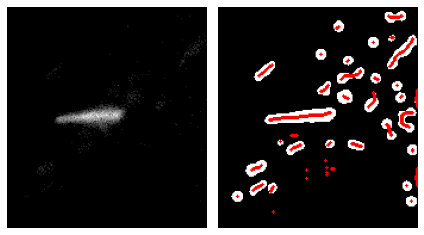

In [70]:
fig, axes = plt.subplots(1, 2)
ax = axes.ravel()

# PANEL A
# display an arbitrary image

# image_raw = iio.imread('Cilia_test/220203_rpe_cilia_live_001_xy01-0024.tif',
#                        format='tiff')

ax[0].imshow(image0, cmap='gray')
ax[0].set_axis_off()

# add a 300nm scale bar
height, width = image0.shape
#scalenm = image.meta['Scan']['PixelHeight'] * 10**9
scale = 15.3846


# PANEL B
# Next, show the smoothed binary image and corresponding skeleton
radius = int(np.ceil(2/scale))
sigma = 50/scale

print ("sigma=", sigma)
print ("radius=", radius)
thresholded = threshold(image0, sigma=sigma,
                        radius=radius, offset=0.0)
#                         smooth_method='gaussian')
viz = np.zeros(image0.shape + (3,), dtype=float)
viz[thresholded] = [1, 1, 1]
skeleton = morphology.skeletonize(thresholded)
fat_skeleton = morphology.binary_dilation(skeleton)

viz[fat_skeleton] = [1, 0, 0]
ax[1].imshow(viz)
ax[1].set_axis_off()


fig.tight_layout()


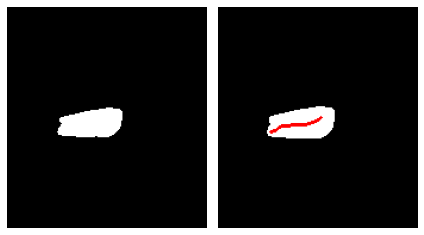

In [271]:
fig, axes = plt.subplots(1, 2)
ax = axes.ravel()

# PANEL A
# display an arbitrary image
# crop = (slice(20, -20),) * 2
image_raw = iio.imread('Cilia_test2/220203_rpe_cilia_live_001_xy01-cilia1_otsu0001.tif',
                       format='tiff')
image = image_raw[crop]
ax[0].imshow(image_raw, cmap='gray')
ax[0].set_axis_off()




# PANEL B
# Next, show the smoothed binary image and corresponding skeleton
radius = int(np.ceil(50/scalenm))
sigma = radius * 0.1
thresholded = threshold(image_raw, sigma=sigma,
                        radius=radius, offset=10,
                        smooth_method='gaussian')
viz = np.zeros(image_raw.shape + (3,), dtype=float)
viz[thresholded] = [1, 1, 1]
skeleton = morphology.skeletonize(thresholded)
fat_skeleton = morphology.binary_dilation(skeleton)

viz[fat_skeleton] = [1, 0, 0]
ax[1].imshow(viz)
ax[1].set_axis_off()


fig.tight_layout()


In [178]:
from skimage import morphology
from skan.csr import skeleton_to_csgraph
from skan import Skeleton, summarize

cilia_binary_file = "/Volumes/Xiang4TData/STMND1/220203_RPE_Cilia_Live/220203_rpe_cilia_live_001_xy09_cilia3_processed/Binary_Images/bin_thrshld_bkg_220203_rpe_cilia_live_001_xy09_cilia3-0001.tif"
spacing = 15.3846 #pixels/micron
spacing_micron = 1/spacing  # micron per pixel    


binary0 = iio.imread(cilia_binary_file, format='tiff')

skeleton0 = morphology.skeletonize(binary0)

pixel_graph, coordinates, degrees = skeleton_to_csgraph(skeleton0) 

branch_data = summarize(Skeleton(skeleton0, spacing=spacing_micron))
# branch_data.head()
branch_data

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,1,1,13,0.313848,0,1.0,0.0,1.000000,5.000000,4.000000,2.000000,0.065000,0.325000,0.260000,0.130000,0.275772
1,2,2,26,0.692696,0,1.0,0.0,1.000000,15.000000,8.000000,9.000000,0.065000,0.975001,0.520001,0.585001,0.599271
2,3,8,32,0.746544,0,1.0,0.0,2.000000,49.000000,9.000000,57.000000,0.130000,3.185003,0.585001,3.705004,0.690960
3,4,18,27,0.402150,1,1.0,0.0,5.000000,33.000000,9.000000,28.750000,0.325000,2.145002,0.585001,1.868752,0.379360
4,4,27,41,0.509860,1,1.0,0.0,9.000000,28.750000,12.000000,22.000000,0.585001,1.868752,0.780001,1.430001,0.480132
5,4,27,47,0.440227,1,1.0,0.0,9.000000,28.750000,14.000000,32.000000,0.585001,1.868752,0.910001,2.080002,0.387623
6,5,29,40,0.333735,1,1.0,0.0,16.666667,1.333333,12.000000,0.000000,1.083334,0.086667,0.780001,0.000000,0.315472
7,5,29,50,0.202403,1,1.0,0.0,16.666667,1.333333,16.000000,4.000000,1.083334,0.086667,1.040001,0.260000,0.178668
8,5,29,58,0.317565,1,1.0,0.0,16.666667,1.333333,21.000000,0.000000,1.083334,0.086667,1.365001,0.000000,0.294699
9,6,30,76,0.248848,1,1.0,0.0,29.000000,2.000000,26.000000,0.000000,1.885002,0.130000,1.690002,0.000000,0.234361


In [233]:
def process_binary_cilia_image(cilia_binary_file, image_format, scale_metadata_path):
    
    
    image = imageio.imread(cilia_binary_file, format=image_format)
    scale = pipe._get_scale(image, scale_metadata_path)    

    scale_micron = 1/scale

    skeleton = morphology.skeletonize(image)
    pixel_graph, coordinates, degrees = skeleton_to_csgraph(skeleton) 
    framedata = summarize(Skeleton(skeleton, spacing=spacing_micron))
    framedata['scale'] = scale_micron
    framedata['filename'] = cilia_binary_file.split("/")[-1]   
    framedata['time'] = time_point(cilia_binary_file)

    cilia_skl = framedata.loc[[framedata['branch-distance'].idxmax()]]

    
    return framedata, cilia_skl


CPU_COUNT = int(os.environ.get('CPU_COUNT', mp.cpu_count()))
def process_binary_cilia_images(filenames, image_format, 
                                scale_metadata_path, num_threads=CPU_COUNT):

    
    image_format = None if image_format == 'auto' else image_format
    results = []
    image_results = []
    cilia_results = []
    with ThreadPoolExecutor(max_workers=num_threads) as ex:
        future_data = {ex.submit(process_binary_cilia_image, filename,
                                 image_format, scale_metadata_path): filename
                       for filename in filenames}
        for completed_data in tqdm(as_completed(future_data)):
            framedata, cilia_skl = completed_data.result()
            filename = future_data[completed_data]
            results.append(framedata)
            cilia_results.append(cilia_skl)

    
            yield filename,framedata, cilia_skl      
    yield pd.concat(cilia_results)


In [262]:
import toolz as tz
from glob import glob


binary_cilia_files = glob('/Volumes/Xiang4TData/STMND1/220203_RPE_Cilia_Live/220203_rpe_cilia_live_001_xy10_cilia2_processed/Binary_Images/*.tif')
# cilia_files = glob('/Volumes/Xiang4TData/STMND1/220203_RPE_Cilia_Live/220203_rpe_cilia_live_001_xy04_cilia1_processed/bkgSub_Images/*.tif')

print (tz.last(binary_cilia_files))


cilia_data= tz.last(process_binary_cilia_images(
    binary_cilia_files,
    image_format='auto',
    scale_metadata_path= 15.3846,
))



output_name = binary_cilia_files[0].split('-')[0]+"_binary_summary.csv"
cilia_data_sorted = cilia_data.sort_values("time")
cilia_data_sorted.to_csv(output_name, index=False)


9it [00:00, 82.63it/s]

/Volumes/Xiang4TData/STMND1/220203_RPE_Cilia_Live/220203_rpe_cilia_live_001_xy10_cilia2_processed/Binary_Images/bin_thrshld_bkg_220203_rpe_cilia_live_001_xy10_cilia2-0120.tif


121it [00:01, 106.06it/s]


In [198]:
cilia_binary_file = "/Volumes/Xiang4TData/STMND1/220203_RPE_Cilia_Live/220203_rpe_cilia_live_001_xy01_cilia1_processed/Binary_Images/thrshld_thrshld_bkg_220203_rpe_cilia_live_001_xy01_cilia1-0001.tif"
spacing = 15.3846 #pixels/micron
spacing_micron = 1/spacing  # micron per pixel    


framedata, cilia_skl = process_binary_cilia_image(cilia_binary_file, 
                           new_output_path = "/Volumes/Xiang4TData/STMND1/220203_RPE_Cilia_Live/220203_rpe_cilia_live_001_xy01_cilia1_processed/",
                           image_format='tiff',
                           scale_metadata_path = spacing)

framedata
# cilia_skl

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance,scale,filename,time
0,2,2,16,1.017697,0,1.0,0.0,23.0,167.0,37.0,167.0,1.495001,10.855011,2.405002,10.855011,0.910001,0.065,bkg_220203_rpe_cilia_live_001_xy10_cilia1-0120...,120
1,3,17,28,0.616544,0,1.0,0.0,39.0,154.0,46.0,148.0,2.535003,10.010010,2.990003,9.620010,0.599271,0.065,bkg_220203_rpe_cilia_live_001_xy10_cilia1-0120...,120
2,4,22,24,0.221924,0,1.0,0.0,42.0,85.0,43.0,82.0,2.730003,5.525006,2.795003,5.330005,0.205548,0.065,bkg_220203_rpe_cilia_live_001_xy10_cilia1-0120...,120
3,12,36,42,0.156924,0,1.0,0.0,65.0,99.0,67.0,100.0,4.225004,6.435006,4.355004,6.500007,0.145345,0.065,bkg_220203_rpe_cilia_live_001_xy10_cilia1-0120...,120
4,22,48,50,0.130000,0,1.0,0.0,75.0,149.0,75.0,151.0,4.875005,9.685010,4.875005,9.815010,0.130000,0.065,bkg_220203_rpe_cilia_live_001_xy10_cilia1-0120...,120
5,23,51,52,0.065000,0,1.0,0.0,88.0,127.0,88.0,128.0,5.720006,8.255008,5.720006,8.320008,0.065000,0.065,bkg_220203_rpe_cilia_live_001_xy10_cilia1-0120...,120
6,24,53,54,0.065000,0,1.0,0.0,92.0,111.0,92.0,112.0,5.980006,7.215007,5.980006,7.280007,0.065000,0.065,bkg_220203_rpe_cilia_live_001_xy10_cilia1-0120...,120
7,27,57,59,0.156924,0,1.0,0.0,94.0,156.0,95.0,158.0,6.110006,10.140010,6.175006,10.270010,0.145345,0.065,bkg_220203_rpe_cilia_live_001_xy10_cilia1-0120...,120
8,29,62,64,0.156924,0,1.0,0.0,96.0,161.0,97.0,159.0,6.240006,10.465010,6.305006,10.335010,0.145345,0.065,bkg_220203_rpe_cilia_live_001_xy10_cilia1-0120...,120
9,31,84,105,3.135775,0,1.0,0.0,98.0,91.0,101.0,44.0,6.370006,5.915006,6.565007,2.860003,3.061220,0.065,bkg_220203_rpe_cilia_live_001_xy10_cilia1-0120...,120
